## Download the dataset from the following link before using this notebook (Chikusei Centre scene):

##  https://www.kaggle.com/datasets/mingliu123/chikusei

## Import required libraries

In [1]:
import numpy as np
import h5py
import random
from scipy.io import loadmat
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Add, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU available. Using:", gpus[0])
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("❌ GPU not available. Running on CPU.")

2025-08-01 11:32:21.990395: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 11:32:22.014709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754037142.031327 2088249 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754037142.036621 2088249 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 11:32:22.054641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

✅ GPU available. Using: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


##  Reproducibility Setup ( Set a consistent random seed for NumPy, TensorFlow, and Python's random module to ensure the same results on each run)

In [2]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

##  Load the Chikusei Dataset

In [3]:
# -----------------------------
# Load Chikusei dataset
# -----------------------------
with h5py.File("Chikusei.mat", "r") as f:
    raw_data = f['chikusei'][:]

# Transpose to (H, W, B)
if raw_data.shape[0] <= 300:
    hyperspectral_image = raw_data.transpose(1, 2, 0)
else:
    hyperspectral_image = raw_data

print("Original image shape:", hyperspectral_image.shape)

Original image shape: (2335, 2517, 128)


##  Parameter Initialization for dataset preprocessing only

In [4]:
# -----------------------------
# Parameters
# -----------------------------
crop_height = 512
crop_width = 512
crop_bands = 128

test_patch_size = (128, 128)
train_patch_size = (128, 128)
downscale_factor = 8
nodata_value = 15000
overlap = 32
validation_ratio = 0.1

## Crop center region for training and testing 

In [5]:
# -----------------------------
# Crop center region
# -----------------------------
H, W, B = hyperspectral_image.shape
start_i = (H - crop_height) // 2
start_j = (W - crop_width) // 2

cropped_image = hyperspectral_image[start_i:start_i + crop_height,
                                    start_j:start_j + crop_width,
                                    :crop_bands]

print("Cropped subimage shape:", cropped_image.shape)

Cropped subimage shape: (512, 512, 128)


## Extract test set

In [6]:
# -----------------------------
# Extract test set: 2 non-overlapping patches from top rows
# -----------------------------
test_hr_list, test_lr_list = [], []
patch_h, patch_w = test_patch_size

for j in range(0, 2 * patch_w, patch_w):
    if j + patch_w > crop_width:
        continue

    patch = cropped_image[0:patch_h, j:j + patch_w, :]
    if patch.shape[:2] != test_patch_size or np.any(patch >= nodata_value):
        continue

    patch_tf = tf.convert_to_tensor(patch[np.newaxis, ...], dtype=tf.float32)
    patch_lr_tf = tf.image.resize(
        patch_tf,
        [patch_h // downscale_factor, patch_w // downscale_factor],
        method='area'
    )
    patch_lr = patch_lr_tf[0].numpy()

    test_hr_list.append(patch)
    test_lr_list.append(patch_lr)

X_test_hr = np.stack(test_hr_list)
X_test_lr = np.stack(test_lr_list)

I0000 00:00:1754037191.041699 2088249 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


## Extract Training Patches

In [7]:
# -----------------------------
# Extract training/validation from remaining region
# -----------------------------
train_hr, train_lr = [], []
stride = train_patch_size[0] - overlap
train_h, train_w = train_patch_size

for i in range(patch_h, crop_height - train_h + 1, stride):
    for j in range(0, crop_width - train_w + 1, stride):
        patch = cropped_image[i:i + train_h, j:j + train_w, :]

        if patch.shape[:2] != train_patch_size or np.any(patch >= nodata_value):
            continue

        patch_tf = tf.convert_to_tensor(patch[np.newaxis, ...], dtype=tf.float32)
        patch_lr_tf = tf.image.resize(
            patch_tf,
            [train_h // downscale_factor, train_w // downscale_factor],
            method='area'
        )
        patch_lr = patch_lr_tf[0].numpy()

        train_hr.append(patch)
        train_lr.append(patch_lr)

train_hr = np.array(train_hr)
train_lr = np.array(train_lr)


## Validation Split FOR train and validation

In [8]:
# -----------------------------
# Split 10% into validation set
# -----------------------------
indices = np.arange(train_hr.shape[0])
np.random.shuffle(indices)

val_count = max(1, int(validation_ratio * len(indices)))
X_validation_hr = train_hr[indices[:val_count]]
X_validation_lr = train_lr[indices[:val_count]]
X_train_hr = train_hr[indices[val_count:]]
X_train_lr = train_lr[indices[val_count:]]

# -----------------------------
# Print dataset shapes
# -----------------------------
print("\n✅ Dataset summary:")
print("X_test_hr:", X_test_hr.shape)
print("X_test_lr:", X_test_lr.shape)
print("X_train_hr:", X_train_hr.shape)
print("X_train_lr:", X_train_lr.shape)
print("X_validation_hr:", X_validation_hr.shape)
print("X_validation_lr:", X_validation_lr.shape)
print(f"Validation samples: {val_count} / {len(indices)}")


✅ Dataset summary:
X_test_hr: (2, 128, 128, 128)
X_test_lr: (2, 16, 16, 128)
X_train_hr: (14, 128, 128, 128)
X_train_lr: (14, 16, 16, 128)
X_validation_hr: (1, 128, 128, 128)
X_validation_lr: (1, 16, 16, 128)
Validation samples: 1 / 15


##  Model development

In [9]:

# -----------------------------
# Custom Loss Function: Spatial + Spectral Gradient + MSE
# -----------------------------
def spatial_spectral_gradient_loss(weight_mse=1.0, weight_spatial=0.1, weight_spectral=0.1):
    def loss_fn(y_true, y_pred):
        mse_loss = K.mean(K.square(y_true - y_pred))

        grad_true_x = y_true[:, 1:, :, :] - y_true[:, :-1, :, :]
        grad_pred_x = y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]
        grad_true_y = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
        grad_pred_y = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
        spatial_loss = K.mean(K.square(grad_true_x - grad_pred_x)) + K.mean(K.square(grad_true_y - grad_pred_y))

        grad_true_s = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
        grad_pred_s = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]
        spectral_loss = K.mean(K.square(grad_true_s - grad_pred_s))

        return weight_mse * mse_loss + weight_spatial * spatial_loss + weight_spectral * spectral_loss

    return loss_fn

# -----------------------------
# Residual Block
# -----------------------------
def resnet_block(x, filters):
    shortcut = x
    x = Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# -----------------------------
# Spectral Unmixing Block
# -----------------------------
def spectral_unmixing_block(x, filters):
    x = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(x)
    x = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(x)
    return x

# -----------------------------
# Spectral–Spatial Fusion Block
# -----------------------------
def spectral_spatial_fusion_block(x, filters):
    spatial = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    spectral = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(x)
    fused = Concatenate()([spatial, spectral])
    fused = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(fused)
    return fused

# -----------------------------
# Model Architecture (Fully Convolutional)
# -----------------------------
def build_simple_sr_model(input_shape=(None, None, 128)):
    inputs = Input(shape=input_shape)

    # Pre-Upsampling
    x = UpSampling2D(size=(8, 8), interpolation='bilinear')(inputs)

    x = spectral_unmixing_block(x, filters=64)
    x = spectral_spatial_fusion_block(x, filters=64)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)

    for _ in range(3):
        x = resnet_block(x, 64)

    output = Conv2D(input_shape[-1], 3, padding='same', activation='linear')(x)

    return Model(inputs, output, name='SR_Model_PreUpsampling')

# -----------------------------
# Build and Compile Model
# -----------------------------
model = build_simple_sr_model(input_shape=(None, None, 128))

model.compile(
    optimizer='adam',
    loss=spatial_spectral_gradient_loss(
        weight_mse=2.0,
        weight_spatial=0.1,
        weight_spectral=0.1
    ),
    metrics=[MeanSquaredError()]
)

# -----------------------------
# Parameter Count
# -----------------------------
total_params = model.count_params()
size_in_bytes = total_params * 4
size_in_mb = size_in_bytes / (1024 ** 2)

print(f"📢 Model size: {size_in_mb:.2f} MB")
print(f"📊 Total Parameters: {total_params / 1e6:.2f} Million")


📢 Model size: 1.51 MB
📊 Total Parameters: 0.39 Million


Epoch 1/1500


2025-08-01 11:33:14.378046: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1754037197.317744 2088639 service.cc:148] XLA service 0x7f1ef8421bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754037197.317768 2088639 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4899039.0000 - mean_squared_error: 2440383.0000

2025-08-01 11:33:19.877311: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 128 bytes spill stores, 120 bytes spill loads

I0000 00:00:1754037199.895881 2088639 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - loss: 4718893.5000 - mean_squared_error: 2324420.7500

2025-08-01 11:33:22.242668: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 4610806.0000 - mean_squared_error: 2254843.5000 - val_loss: 1967264.0000 - val_mean_squared_error: 929724.5000
Epoch 2/1500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1641827.8750 - mean_squared_error: 759502.2500 - val_loss: 500494.0312 - val_mean_squared_error: 240448.1875
Epoch 3/1500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 621851.7500 - mean_squared_error: 296820.1250 - val_loss: 511652.3750 - val_mean_squared_error: 245651.7188
Epoch 4/1500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 569238.3750 - mean_squared_error: 269810.5312 - val_loss: 372907.0938 - val_mean_squared_error: 178331.6094
Epoch 5/1500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 457686.1562 - mean_squared_error: 217107.5469 - val_loss: 276545.5625 - val_mean_squared_error: 133282.3594
Epoch 6/1500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 366039.0000 - mean_squared_error: 173864.6719 - val_loss: 215828.4688 - val_mean_squared_error: 103694.3281
Epoch 7/1

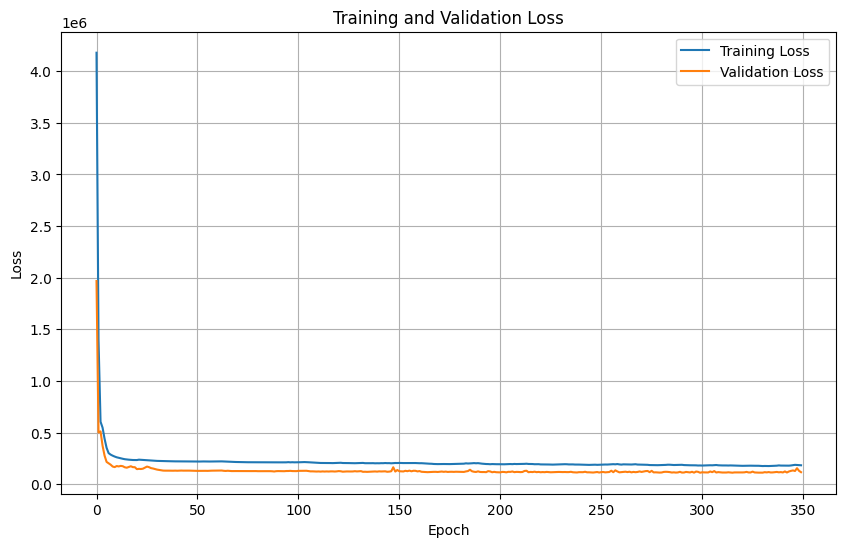

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = model.fit(
    X_train_lr, 
    X_train_hr, 
    epochs=1500, 
    batch_size=4, 
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

##  Save trained model

In [11]:
model.save('Chikusei_8x__saved_model.keras')

## Report the six types of results in terms of PSNR, SSIM, SAM, Correlation Coefficient, ERGAS, and RMSE.

In [12]:
def psnr(y_true, y_pred, max_pixel=None):
    """
    Compute PSNR for each spectral band separately and return the average.
    
    Args:
        y_true: Ground truth image, shape (H, W, B)
        y_pred: Super-resolved image, shape (H, W, B)
        max_pixel: Maximum pixel value (None = use actual max from y_true)
    
    Returns:
        Average PSNR across all bands
    """
    if max_pixel is None:
        max_pixel = np.max(y_true)  # Auto-detect max value if not provided

    B = y_true.shape[-1]  # Number of spectral bands
    psnr_values = []
    
    for i in range(B):  # Loop over bands
        mse = np.mean((y_true[..., i] - y_pred[..., i]) ** 2)
        if mse == 0:
            psnr_values.append(float('inf'))  # Perfect reconstruction
        else:
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    
    return np.mean(psnr_values)  # Average across bands

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")
    
    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
    
    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))
    
    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0
    
    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")
    
    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        
        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse


# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images =  model.predict(X_test_lr)


# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalizedex

2025-08-01 11:34:11.030329: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
Average PSNR on the test set: 29.335280237023653
Average SSIM on the test set: 0.7096532813368693
Average SAM on the test set (in degrees): 3.0799247159931467
Average Correlation Coefficient on the test set: 0.9838236040427469
Average RMSE: 0.038924376222935


/usr/local/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib64/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
